In [15]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [16]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/'
SRS_gain = 10 # gain on the SRS bandpass filter
peak_threshold = 100 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 50 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [17]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2)) 

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [18]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [41]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, binsize=20):
    # rebin data to make the histogram bins less small
    x, y = rebin_histogram(x_data, y_data, binsize)
    
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)
    
    xtick_location = []
    xtick_label = [1,2,3,4,5]

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number = 1 # corresponds to single photoelectron
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 2
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # finding the section of the data around the given peak
        if voltage < 30:
            peak_range = 150
        else:
            peak_range = 500
        # could be causing issues with not getting first peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - 10))
        else:
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - peak_range))
        peak_x = x[cut]
        peak_y = y[cut]
        
        plt.plot(peak_x, peak_y, color='b')
        
        print('Peak: ', peak)
        peak_number+=1 # (goes to n*spe until it reaches max_peak)
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            print('Guess: ', initial_guess)
            print('Params: ', params)
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append([peak, np.nan, np.nan])
            xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100 )
            plt.plot(xx, gauss_fun(xx, *initial_guess), 'b' )
        
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        
        
        xtick_location.append(x[peak])
    
    # Plot the original spectrum and the fitted Gaussian peaks
#     if plot:
#         plt.plot(x, y, color='k')
#         for i in range(len(peak_params)):
#             if not np.isnan(peak_params[i][1]):
#                 plt.plot(x, gauss_fun(x, peak_params[i][0], peak_params[i][1], peak_params[i][2]), 'r--')
#         plt.xticks(peaks_index, peaks_index)
#         plt.show()

        plt.plot(x[peak], y[peak], 'o', label='peaks')
#         plt.plot(x, gauss_fun(x, *initial_guess), color='r')
        plt.plot(x, gauss_fun(x, *params))
    plt.xticks(xtick_location, xtick_label)

    print(xtick_location)
    plt.show()
    return np.array(peak_params), x, y

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_33.90OV_source_0.h5
Distance:  5
Peak:  15
Guess:  [431, 310.0567765567765, 2]
Params:  [431.         310.05677656   2.        ]
Peak:  23
Guess:  [247, 470.0860805860806, 2]
Params:  [247.         470.08608059   2.        ]
Peak:  31
Guess:  [145, 630.1153846153846, 2]
Params:  [145.         630.11538462   2.        ]
Peak:  38
Guess:  [107, 770.1410256410256, 2]
Params:  [107.         770.14102564   2.        ]
Peak:  46
Guess:  [64, 930.1703296703297, 2]
Params:  [ 64.         930.17032967   2.        ]
[310.0567765567765, 470.0860805860806, 630.1153846153846, 770.1410256410256, 930.1703296703297]


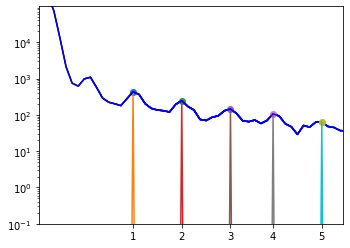

[[  2.         310.05677656          inf]
 [  3.         470.08608059          inf]
 [  4.         630.11538462          inf]
 [  5.         770.14102564          inf]
 [  6.         930.17032967          inf]]
Gain vs volts: [33.9, 154.02820925169763, 2.000364242106581, 'source']


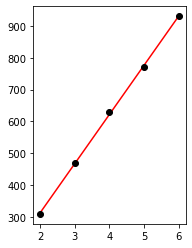

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_33.40OV_source_0.h5
Distance:  5
Peak:  14
Guess:  [505, 290.0531135531136, 2]
Params:  [505.         290.05311355   2.        ]
Peak:  21
Guess:  [239, 430.07875457875457, 2]
Params:  [239.         430.07875458   2.        ]
Peak:  28
Guess:  [140, 570.1043956043957, 2]
Params:  [140.        570.1043956   2.       ]
Peak:  35
Guess:  [93, 710.1300366300366, 2]
Params:  [ 93.         710.13003663   2.        ]
Peak:  43
Guess:  [65, 870.1593406593406, 2]
Params:  [ 65.         870.15934066   2.        ]
[290.0531135531136, 430.07875457875457, 570.1043956043957, 710.1300366300366, 870.1593406593406]


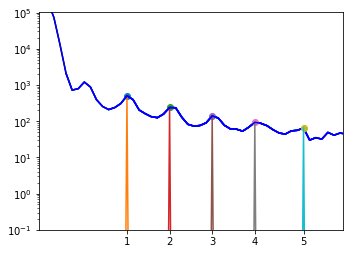

[[  2.         290.05311355          inf]
 [  3.         430.07875458          inf]
 [  4.         570.1043956           inf]
 [  5.         710.13003663          inf]
 [  6.         870.15934066          inf]]
Gain vs volts: [33.4, 144.02637359458444, 2.309824061437731, 'source']


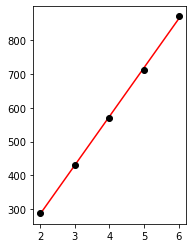

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_32.90OV_source_0.h5
Distance:  5
Peak:  13
Guess:  [532, 270.0494505494505, 2]
Params:  [532.         270.04945055   2.        ]
Peak:  20
Guess:  [253, 410.0750915750916, 2]
Params:  [253.         410.07509158   2.        ]
Peak:  26
Guess:  [151, 530.0970695970695, 2]
Params:  [151.        530.0970696   2.       ]
Peak:  33
Guess:  [109, 670.1227106227107, 2]
Params:  [109.         670.12271062   2.        ]
Peak:  39
Guess:  [57, 790.1446886446886, 2]
Params:  [ 57.         790.14468864   2.        ]
[270.0494505494505, 410.0750915750916, 530.0970695970695, 670.1227106227107, 790.1446886446886]


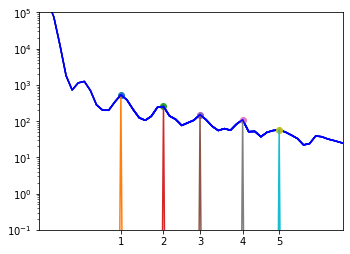

[[  2.         270.04945055          inf]
 [  3.         410.07509158          inf]
 [  4.         530.0970696           inf]
 [  5.         670.12271062          inf]
 [  6.         790.14468864          inf]]
Gain vs volts: [32.9, 130.0238095062032, 2.0003663249722017, 'source']


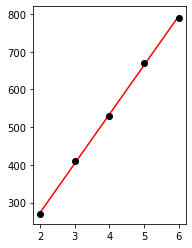

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_32.40OV_source_0.h5
Distance:  5
Peak:  12
Guess:  [544, 250.04578754578753, 2]
Params:  [544.         250.04578755   2.        ]
Peak:  18
Guess:  [239, 370.0677655677656, 2]
Params:  [239.         370.06776557   2.        ]
Peak:  24
Guess:  [134, 490.08974358974353, 2]
Params:  [134.         490.08974359   2.        ]
Peak:  30
Guess:  [81, 610.1117216117216, 2]
Params:  [ 81.         610.11172161   2.        ]
Peak:  36
Guess:  [56, 730.1336996336996, 2]
Params:  [ 56.         730.13369963   2.        ]
[250.04578754578753, 370.0677655677656, 490.08974358974353, 610.1117216117216, 730.1336996336996]


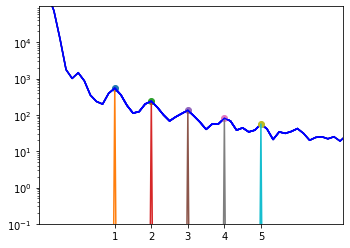

[[  2.         250.04578755          inf]
 [  3.         370.06776557          inf]
 [  4.         490.08974359          inf]
 [  5.         610.11172161          inf]
 [  6.         730.13369963          inf]]
Gain vs volts: [32.4, 120.02197802197797, 2.594538074692306e-14, 'source']


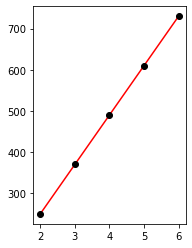

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_31.90OV_source_0.h5
Distance:  2
Peak:  11
Guess:  [517, 230.04212454212455, 2]
Params:  [517.         230.04212454   2.        ]
Peak:  17
Guess:  [215, 350.06410256410254, 2]
Params:  [215.         350.06410256   2.        ]
Peak:  22
Guess:  [113, 450.08241758241763, 2]
Params:  [113.         450.08241758   2.        ]
Peak:  27
Guess:  [98, 550.1007326007326, 2]
Params:  [ 98.        550.1007326   2.       ]
Peak:  32
Guess:  [46, 650.1190476190476, 2]
Params:  [ 46.         650.11904762   2.        ]
[230.04212454212455, 350.06410256410254, 450.08241758241763, 550.1007326007326, 650.1190476190476]


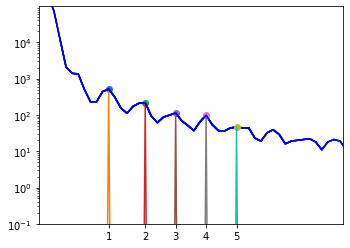

[[  2.         230.04212454          inf]
 [  3.         350.06410256          inf]
 [  4.         450.08241758          inf]
 [  5.         550.1007326           inf]
 [  6.         650.11904762          inf]]
Gain vs volts: [31.9, 104.01904789062684, 2.309823648426138, 'source']


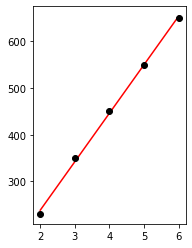

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_31.40OV_source_0.h5
Distance:  2
Peak:  15
Guess:  [212, 310.0567765567765, 2]
Params:  [212.         310.05677656   2.        ]
Peak:  19
Guess:  [146, 390.07142857142856, 2]
Params:  [146.         390.07142857   2.        ]
Peak:  24
Guess:  [74, 490.08974358974353, 2]
Params:  [ 74.         490.08974359   2.        ]
Peak:  29
Guess:  [50, 590.1080586080586, 2]
Params:  [ 50.         590.10805861   2.        ]
Peak:  34
Guess:  [34, 690.1263736263736, 2]
Params:  [ 34.         690.12637363   2.        ]
[310.0567765567765, 390.07142857142856, 490.08974358974353, 590.1080586080586, 690.1263736263736]


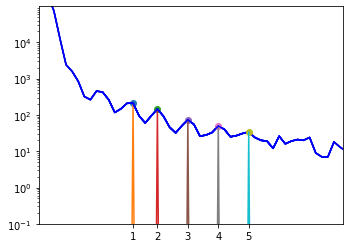

[[  2.         310.05677656          inf]
 [  3.         390.07142857          inf]
 [  4.         490.08974359          inf]
 [  5.         590.10805861          inf]
 [  6.         690.12637363          inf]]
Gain vs volts: [31.4, 96.01758241758242, 2.309824188302242, 'source']


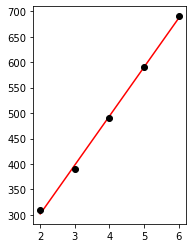

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_30.90OV_source_0.h5
Distance:  2
Peak:  13
Guess:  [227, 270.0494505494505, 2]
Params:  [227.         270.04945055   2.        ]
Peak:  17
Guess:  [119, 350.06410256410254, 2]
Params:  [119.         350.06410256   2.        ]
Peak:  21
Guess:  [77, 430.07875457875457, 2]
Params:  [ 77.         430.07875458   2.        ]
Peak:  26
Guess:  [44, 530.0970695970695, 2]
Params:  [ 44.        530.0970696   2.       ]
Peak:  30
Guess:  [28, 610.1117216117216, 2]
Params:  [ 28.         610.11172161   2.        ]
[270.0494505494505, 350.06410256410254, 430.07875457875457, 530.0970695970695, 610.1117216117216]


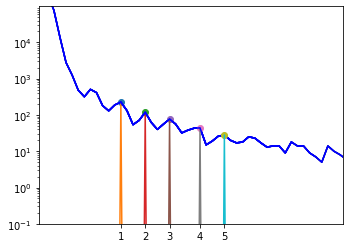

[[  2.         270.04945055          inf]
 [  3.         350.06410256          inf]
 [  4.         430.07875458          inf]
 [  5.         530.0970696           inf]
 [  6.         610.11172161          inf]]
Gain vs volts: [30.9, 86.0157511313068, 2.0003662383909635, 'source']


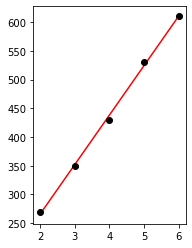

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_30.40OV_source_0.h5
Distance:  2
Peak:  11
Guess:  [191, 230.04212454212455, 2]
Params:  [191.         230.04212454   2.        ]
Peak:  15
Guess:  [99, 310.0567765567765, 2]
Params:  [ 99.         310.05677656   2.        ]
Peak:  18
Guess:  [67, 370.0677655677656, 2]
Params:  [ 67.         370.06776557   2.        ]
Peak:  22
Guess:  [44, 450.08241758241763, 2]
Params:  [ 44.         450.08241758   2.        ]
Peak:  26
Guess:  [33, 530.0970695970695, 2]
Params:  [ 33.        530.0970696   2.       ]
[230.04212454212455, 310.0567765567765, 370.0677655677656, 450.08241758241763, 530.0970695970695]


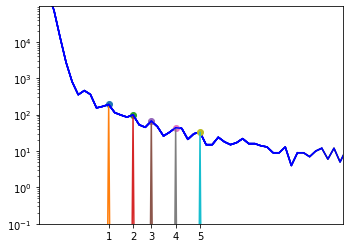

[[  2.         230.04212454          inf]
 [  3.         310.05677656          inf]
 [  4.         370.06776557          inf]
 [  5.         450.08241758          inf]
 [  6.         530.0970696           inf]]
Gain vs volts: [30.4, 74.0135532292262, 2.0003661734013063, 'source']


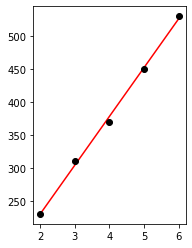

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_29.90OV_source_0.h5
Distance:  2
Peak:  12
Guess:  [98, 250.04578754578753, 2]
Params:  [ 98.         250.04578755   2.        ]
Peak:  15
Guess:  [85, 310.0567765567765, 2]
Params:  [ 85.         310.05677656   2.        ]
Peak:  18
Guess:  [51, 370.0677655677656, 2]
Params:  [ 51.         370.06776557   2.        ]
Peak:  21
Guess:  [35, 430.07875457875457, 2]
Params:  [ 35.         430.07875458   2.        ]
Peak:  25
Guess:  [23, 510.0934065934066, 2]
Params:  [ 23.         510.09340659   2.        ]
[250.04578754578753, 310.0567765567765, 370.0677655677656, 430.07875457875457, 510.0934065934066]


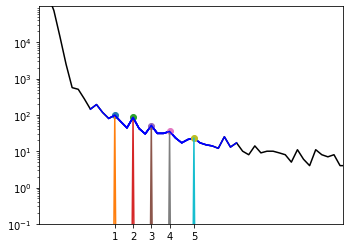

[[  2.         250.04578755          inf]
 [  3.         310.05677656          inf]
 [  4.         370.06776557          inf]
 [  5.         430.07875458          inf]
 [  6.         510.09340659          inf]]
Gain vs volts: [29.9, 64.01172182447988, 2.3098240531759213, 'source']


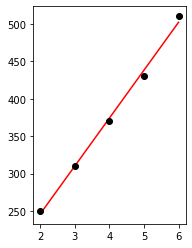

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_29.40OV_source_0.h5
Distance:  2
Peak:  12
Guess:  [57, 250.04578754578753, 2]
Params:  [ 57.         250.04578755   2.        ]
Peak:  14
Guess:  [55, 290.0531135531136, 2]
Params:  [ 55.         290.05311355   2.        ]
Peak:  17
Guess:  [29, 350.06410256410254, 2]
Params:  [ 29.         350.06410256   2.        ]
Peak:  20
Guess:  [24, 410.0750915750916, 2]
Params:  [ 24.         410.07509158   2.        ]
Peak:  22
Guess:  [20, 450.08241758241763, 2]
Params:  [ 20.         450.08241758   2.        ]
[250.04578754578753, 290.0531135531136, 350.06410256410254, 410.0750915750916, 450.08241758241763]


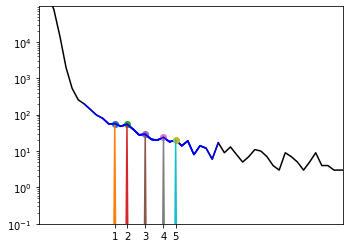

[[  2.         250.04578755          inf]
 [  3.         290.05311355          inf]
 [  4.         350.06410256          inf]
 [  5.         410.07509158          inf]
 [  6.         450.08241758          inf]]
Gain vs volts: [29.4, 52.00952378018, 2.3098240273623336, 'source']


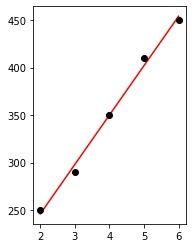

In [43]:
guess_1pe = 75 #10 * SRS_gain/10 - pedestal ## based on highest gain data
guess_sig = 0.1

#distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15] # step5, binsize = 25
distances = [5, 5, 5, 5, 2, 2, 2, 2, 2, 2]

gain_vs_volts = []
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data

    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 20)

    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 1000)
 
    # Either issue with skipping first peak  is here or above 
    if(len(gain_vs_volts) > 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs, post_bin_x, post_bin_y = find_peaks_and_fit(bin_num, mca_hist, file_volts, min_distance=dist)

#     plt.xlim(0, guess_1pe*6)

    plt.subplot(1,2,2)
    print(pe_locs)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    fpts = ~np.isnan(pe_locs[:,1])
    if(np.sum(fpts) < 3):
        continue
    gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

    xx = pe_locs[fpts, 0]
    plt.plot(xx, lin_fun(xx, *gain_bp), 'r')
    

    gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )
    print('Gain vs volts:',gain_vs_volts[i])

    plt.show()
    

In [ ]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

In [ ]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [ ]:
print(rows_to_use)

In [ ]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()

In [ ]:
# def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, binsize=25):
#     # try different bin sizes above
#     # rebin data to make the histogram bins less small
#     x, y = rebin_histogram(x_data, y_data, binsize)
    
#     # Find the peaks in the spectrum using the find_peaks function from scipy.signal
#     peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

#     # Fit each peak with a Gaussian function using the curve_fit function from scipy
#     peak_params = []
#     peak_number = 1 # corresponds to single photoelectron
#     for peak in peaks_index:
#         if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
#             break
# #         print(peak)
#         if peak < min_thresh:
#             continue

#         # Initial guess for the Gaussian parameters
#         amplitude_guess = y[peak]
#         mean_guess = x[peak]
#         standard_deviation_guess = 50 # can play with as well
#         initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]

#         # finding the section of the data around the given peak
#         if voltage < 30:
#             peak_range = 150  # peaks spread out at higher voltages
#         else:
#             peak_range = 500
#         if peak_number == 1: # trying to not include the pedestal for the first peak
#             cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - 200))
#         else:
#             cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - peak_range))
#         peak_x = x[cut]
#         peak_y = y[cut]
        
#         print('Peak: ', peak)
#         peak_number+=1 # goes to n*spe until it reaches max_peak

#         # Perform the curve fitting
#         try:
#             params, params_covariance = curve_fit(gauss_fun, x, y, p0=initial_guess)
#             print('Guess: ', initial_guess)
#             print('Params: ', params)
#         except RuntimeError as r:
#             print('fit failed')
#             # if  curve fit doesn't work we will use peak amplitude and center from find_peaks
#             peak_params.append([peak, np.nan, np.nan])
#             xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100)
#             plt.plot( xx, gauss_fun(xx, *initial_guess), 'b')
#             continue
#         peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
#         peak_number+=1 # (goes to n*spe until it reaches max_peak)
    
#     # Plot the original spectrum and the fitted Gaussian peaks
#         plt.plot(x[peak], y[peak], 'o', label='peaks')
# #     plt.plot(x, y, 'o', label='Original spectrum')
#         plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
#     #for params in peak_params:
#         #print(params)
#         #plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
#     #plt.legend()
#     plt.show()
#     return np.array(peak_params), x, y